In [2]:
#!pip install imblearn
#!pip install wordcloud
#!pip install heapq

In [1]:
%matplotlib inline
import heapq
import pandas as pd
import numpy as np
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import warnings
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import recall_score
from scipy import stats
plt.style.use('seaborn')
warnings.filterwarnings(action='ignore')
output_dir = 'modelOutput'
pd.options.display.max_colwidth=50;

In [35]:
airbnbdata = pd.read_excel('listings_cleaned_v1.xlsm')

In [3]:
for col in airbnbdata.columns:
    print(col)

id
listing_url
name
summary
space
description
host_id
host_name
host_listings_count
neighbourhood_cleansed
city
state
zipcode
country
latitude
longitude
property_type
room_type
price
number_of_reviews
review_scores_rating
average_review_score
reviews_per_month


<h1>Clean and Preprocess Data</h1>

In [4]:
df1clean = airbnbdata
df1clean.iloc[0]

id                                                                 36489333
listing_url                           https://www.airbnb.com/rooms/36489333
name                                     Wonderful peaceful historical safe
summary                   Entire house to yourself! Not sharing  Home is...
space                                                                   NaN
description               Entire house to yourself! Not sharing  Home is...
host_id                                                           136332616
host_name                                                         Arshak M.
host_listings_count                                                      10
neighbourhood_cleansed                                             Glendale
city                                                               Glendale
state                                                                    CA
zipcode                                                               91201
country     

In [5]:
#drop rows with nulls in columns
df1clean = df1clean.dropna(subset=['id'])
df1clean = df1clean.dropna(subset=['listing_url'])
df1clean = df1clean.dropna(subset=['name'])
df1clean = df1clean.dropna(subset=['summary'])
df1clean = df1clean.dropna(subset=['space'])
df1clean = df1clean.dropna(subset=['description'])
df1clean = df1clean.dropna(subset=['host_id'])
df1clean = df1clean.dropna(subset=['host_name'])
df1clean = df1clean.dropna(subset=['host_listings_count'])
df1clean = df1clean.dropna(subset=['neighbourhood_cleansed'])
df1clean = df1clean.dropna(subset=['city'])
df1clean = df1clean.dropna(subset=['state'])
df1clean = df1clean.dropna(subset=['zipcode'])
df1clean = df1clean.dropna(subset=['country'])
df1clean = df1clean.dropna(subset=['latitude'])
df1clean = df1clean.dropna(subset=['longitude'])
df1clean = df1clean.dropna(subset=['property_type'])
df1clean = df1clean.dropna(subset=['room_type'])
df1clean = df1clean.dropna(subset=['price'])
df1clean = df1clean.dropna(subset=['number_of_reviews'])
df1clean = df1clean.dropna(subset=['review_scores_rating'])
df1clean = df1clean.dropna(subset=['average_review_score'])
df1clean = df1clean.dropna(subset=['reviews_per_month'])
#round score rating
df1clean['average_review_score'] = df1clean['average_review_score']/2
df1clean.average_review_score = df1clean.average_review_score.round()
df1clean.average_review_score[df1clean['average_review_score']== 1] = '1'
df1clean.average_review_score[df1clean['average_review_score']== 2] = '1'
df1clean.average_review_score[df1clean['average_review_score']== 3] = '1'
df1clean.average_review_score[df1clean['average_review_score']== 4] = '0'
df1clean.average_review_score[df1clean['average_review_score']== 5] = '0'

In [6]:
df1clean.neighbourhood_cleansed=df1clean.neighbourhood_cleansed.replace(' ', '_', regex=True)
pd.Series(' '.join(df1clean.neighbourhood_cleansed).split()).value_counts()[:20]

Venice                  1845
Hollywood               1629
Long_Beach              1156
Downtown                1079
Santa_Monica             709
Hollywood_Hills          697
Westlake                 630
Silver_Lake              569
Koreatown                541
Mid-Wilshire             505
Echo_Park                505
East_Hollywood           493
West_Hollywood           472
Hollywood_Hills_West     435
Sawtelle                 418
Mid-City                 416
Beverly_Grove            396
North_Hollywood          391
Westwood                 371
Los_Feliz                351
dtype: int64

<h1>Word Frequency</h1>

In [7]:
df1freq = airbnbdata
df1freq.head(1)

,id,listing_url,name,summary,space,description,host_id,host_name,host_listings_count,neighbourhood_cleansed,...,country,latitude,longitude,property_type,room_type,price,number_of_reviews,review_scores_rating,average_review_score,reviews_per_month
0,36489333,https://www.airbnb.com/rooms/36489333,Wonderful peaceful historical safe,Entire house to yourself! Not sharing Home is...,NaN,Entire house to yourself! Not sharing Home is...,136332616,Arshak M.,10.0,Glendale,...,United States,34.17452,-118.28269,House,Entire home/apt,10,3,73.0,8.0,1.61


In [8]:
corpus_freq=df1freq['description'].astype(str)
type(corpus_freq)

pandas.core.series.Series

In [9]:
def normalize_document (doc):
    #lowercase and remove special characters\whitespace
    doc=re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I ignore case sensitive, ASCII-only matching
    doc=re.sub(r"\b[a-zA-Z]\b", '', doc, re.I|re.A)
    doc=doc.lower()
    doc=doc.strip()
    #tokenize document
    tokens=wpt.tokenize(doc)
    #filter stopwords out of document
    filtered_tokens=[token for token in tokens if token not in stop_words]
    #re-create documenr from filtered tokens
    doc=' '.join(filtered_tokens)
    return doc

In [10]:
normalize_corpus=np.vectorize(normalize_document)

In [11]:
wpt=nltk.WordPunctTokenizer()
stop_words=nltk.corpus.stopwords.words('english')

In [12]:
norm_corpus=normalize_corpus(corpus_freq)

In [13]:
print (norm_corpus[997])

nice clean room beautiful suburban home relax stay affordable quiet area explore southern california close many attractions save money staying suburbs uber local attractions newly renovated house long term stay available disclaimer pool old cleaned professionally week jacuzzi work small lb rescue dog stays mostly room local cheap budget motel charges night keep things perspective stateforeign visitors please note housing expensive los angeles compared places america please compare place standards facilities beyond youre paying im friendly responsive keep clean place please decent person rate terms giving others star review makes feel like powerful person please dont book place youre decent reasonable human


In [14]:
word2count = {}
for data_corpus in norm_corpus:
    words = nltk.word_tokenize(data_corpus)
    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

In [15]:
most_freq = heapq.nlargest(20, word2count, key=word2count.get)
most_freq

['room',
 'private',
 'å',
 'kitchen',
 'bedroom',
 'house',
 'home',
 'hollywood',
 'parking',
 'bed',
 'beach',
 'apartment',
 'located',
 'bathroom',
 'living',
 'restaurants',
 'la',
 'space',
 'access',
 'area']

<h1> Create WordCloud </h1>

In [16]:
def make_wordcloud(words):

    text = ""
    for word in words:
        text = text + " " + word

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords,colormap="twilight",width=1920, height=1080,max_font_size=200, max_words=200, background_color="white").generate(text)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation="gaussian")
    plt.axis("off")
    plt.show()

In [19]:
neighbourhood = df1clean['neighbourhood_cleansed']

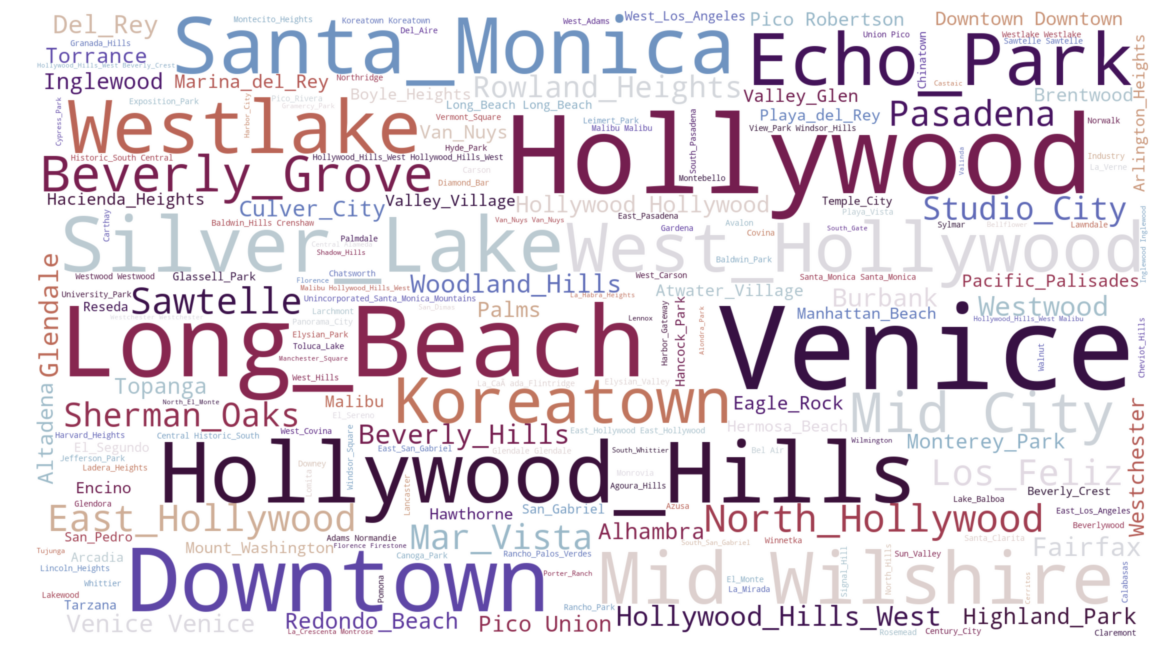

In [20]:
make_wordcloud(neighbourhood)

<h1>Split Data into Training and Testing Set </h1>

In [21]:
df1clean['average_review_score'].value_counts()/df1clean['average_review_score'].count()

0    0.992379
1    0.007621
Name: average_review_score, dtype: float64

In [22]:
df1clean['average_review_score'] = pd.to_numeric(df1clean['average_review_score'])
df1clean.average_review_score.value_counts()

0    27347
1      210
Name: average_review_score, dtype: int64

In [23]:
model_variables = ['host_name','price','neighbourhood_cleansed', 'property_type','room_type','average_review_score']
price_data_relevent = df1clean[model_variables]

In [24]:
#Create Dummies
price_relevant_enconded = pd.get_dummies(price_data_relevent)

In [25]:
#Create Training and Test Sets
training_features, test_features, \
training_target, test_target, = train_test_split(price_relevant_enconded.drop(['average_review_score'], axis=1),
                                               price_relevant_enconded['average_review_score'],
                                               test_size = .4,
                                               random_state=12)

In [26]:
#Oversample minority class on training data.
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .4,
                                                  random_state=12)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)


<h1>Single Decision Tree</h1>

In [27]:
tree = DecisionTreeClassifier(random_state=12)
tree.fit(x_train_res, y_train_res)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1567 nodes with maximum depth 101.


In [28]:
train_probs = tree.predict_proba(x_train_res)[:, 1]
probs = tree.predict_proba(x_val)[:, 1]

train_predictions = tree.predict(x_train_res)
predictions = tree.predict(x_val)

In [29]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_val, probs)}')

Train ROC AUC Score: 0.9999925609263234
Test ROC AUC  Score: 0.5354739526128385


In [30]:
print(f'Baseline ROC AUC: {roc_auc_score(y_val, [1 for _ in range(len(y_val))])}')

Baseline ROC AUC: 0.5


In [31]:
#test = x_val
#test_labels = y_val 
#train = x_train_res
#train label = y_train_res
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_val, [1 for _ in range(len(y_val))])
    baseline['precision'] = precision_score(y_val, [1 for _ in range(len(y_val))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_val, predictions)
    results['precision'] = precision_score(y_val, predictions)
    results['roc'] = roc_auc_score(y_val, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions)
    train_results['precision'] = precision_score(y_train_res, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
    model_fpr, model_tpr, _ = roc_curve(y_val, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [32]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 6232, 1.0: 354, 0.25: 11, 0.986159169550173: 6, 0.16666666666666666: 6, 0.14285714285714285: 3, 0.5: 2})
Counter({0: 6254, 1: 360})


Recall Baseline: 1.0 Test: 0.13 Train: 1.0
Precision Baseline: 0.01 Test: 0.02 Train: 1.0
Roc Baseline: 0.5 Test: 0.54 Train: 1.0


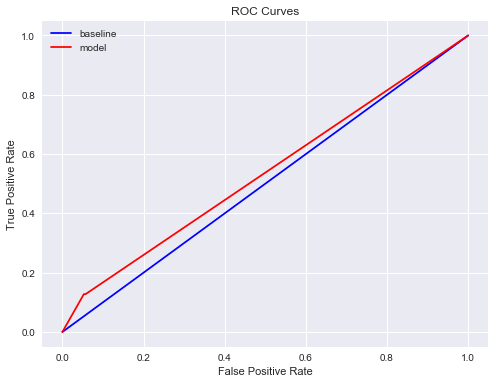

In [33]:
evaluate_model(predictions, probs, train_predictions, train_probs)

<h1>Random Forest</h1>

In [34]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [34]:
n_nodes = []
max_depths = []

for ind_tree in clf_rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 3161
Average maximum depth 257


In [35]:
print('Validation Results')
print('Mean Accuracy:',clf_rf.score(x_val, y_val))
print('Recall:',recall_score(y_val, clf_rf.predict(x_val))) 
print('\nTest Results') 
print('Mean Accuracy:',clf_rf.score(test_features, test_target))
print('Recall:',recall_score(test_target, clf_rf.predict(test_features))) 

Validation Results
Mean Accuracy: 0.9752041124886605
Recall: 0.06666666666666667

Test Results
Mean Accuracy: 0.9711512292479362
Recall: 0.052083333333333336


In [36]:
#Credit to Nick Becker for Oversampling code - https://github.com/beckernick

In [37]:
# Make probability predictions
train_probs1 = clf_rf.predict_proba(x_train_res)[:, 1]
probs1 = clf_rf.predict_proba(x_val)[:, 1]

train_predictions1 = clf_rf.predict(x_train_res)
predictions1 = clf_rf.predict(x_val)

In [38]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_probs1)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_val, probs1)}')

Train ROC AUC Score: 0.9999898549291972
Test ROC AUC  Score: 0.5738096446271206


In [39]:
print(f'Baseline ROC AUC: {roc_auc_score(y_val, [1 for _ in range(len(y_val))])}')
#Our model outperforms a baseline guess. Data is extremely overfit; perfect ROC AUC



Baseline ROC AUC: 0.5


In [40]:
def evaluate_model(predictions1, probs1, train_predictions1, train_probs1):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_val, [1 for _ in range(len(y_val))])
    baseline['precision'] = precision_score(y_val, [1 for _ in range(len(y_val))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_val, predictions1)
    results['precision'] = precision_score(y_val, predictions1)
    results['roc'] = roc_auc_score(y_val, probs1)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions1)
    train_results['precision'] = precision_score(y_train_res, train_predictions1)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs1)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
    model_fpr, model_tpr, _ = roc_curve(y_val, probs1)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [41]:
from collections import Counter
print(Counter(probs1))
print(Counter(predictions1))

Counter({0.0: 2294, 0.01: 1007, 0.02: 661, 0.03: 449, 0.04: 280, 0.05: 251, 0.06: 180, 0.07: 156, 0.08: 101, 0.09: 86, 0.12: 84, 0.11: 84, 0.13: 71, 0.1: 66, 0.14: 52, 0.15: 51, 0.16: 42, 0.18: 29, 0.23: 29, 0.26: 27, 0.21: 25, 0.2: 25, 0.22: 24, 0.33: 24, 0.19: 23, 0.17: 23, 0.27: 22, 0.25: 20, 0.3: 18, 0.24: 18, 0.32: 18, 0.28: 18, 0.29: 16, 0.31: 14, 0.37: 12, 0.38: 11, 0.46: 11, 0.36: 11, 0.41: 11, 0.34: 11, 1.0: 10, 0.39: 10, 0.45: 9, 0.43: 9, 0.4: 9, 0.47: 9, 0.42: 8, 0.35: 8, 0.48: 8, 0.44: 7, 0.65: 7, 0.49: 7, 0.54: 6, 0.51: 6, 0.63: 6, 0.04666666666666666: 5, 0.62: 5, 0.85: 5, 0.69: 5, 0.53: 5, 0.72: 4, 0.68: 4, 0.32458333333333345: 4, 0.5: 4, 0.52: 4, 0.97: 4, 0.56: 3, 0.77: 3, 0.81: 3, 0.7: 3, 0.74: 3, 0.042: 2, 0.59: 2, 0.96: 2, 0.61: 2, 0.93: 2, 0.026666666666666665: 2, 0.64: 2, 0.66: 2, 0.67: 2, 0.8: 2, 0.71: 2, 0.83: 2, 0.03666666666666667: 2, 0.9: 2, 0.006666666666666666: 2, 0.78: 2, 0.06628571428571428: 1, 0.0375: 1, 0.215: 1, 0.10166666666666666: 1, 0.2288809523809524

Recall Baseline: 1.0 Test: 0.07 Train: 1.0
Precision Baseline: 0.01 Test: 0.02 Train: 1.0
Roc Baseline: 0.5 Test: 0.57 Train: 1.0


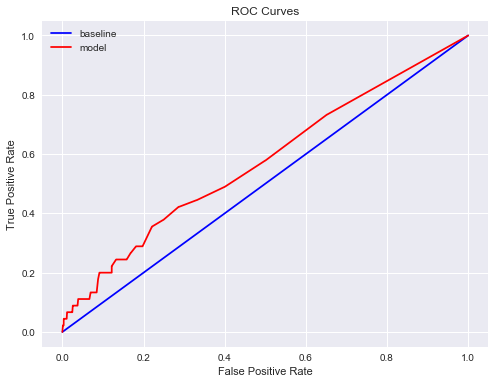

In [42]:
evaluate_model(predictions1, probs1, train_predictions1, train_probs1)

<h1>Random Forest Optimization using RandomSearch</h1>
<body>*****During Testing took between 59 minutes and 99 minutes to process. Please Only Run if time allows.</body>

In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 12)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=12)

# Fit 
rs.fit(x_train_res, y_train_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 84.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [44]:
rs.best_params_

{'n_estimators': 83,
 'min_samples_split': 5,
 'max_leaf_nodes': 49,
 'max_features': 'auto',
 'max_depth': 17,
 'bootstrap': False}

In [45]:
best_model = rs.best_estimator_

In [46]:
train_rf_predictions = best_model.predict(x_train_res)
train_rf_probs = best_model.predict_proba(x_train_res)[:, 1]

rf_predictions = best_model.predict(x_val)
rf_probs = best_model.predict_proba(x_val)[:, 1]

In [47]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 94
Average maximum depth 17


Recall Baseline: 1.0 Test: 0.13 Train: 0.97
Precision Baseline: 0.01 Test: 0.02 Train: 0.96
Roc Baseline: 0.5 Test: 0.65 Train: 0.99


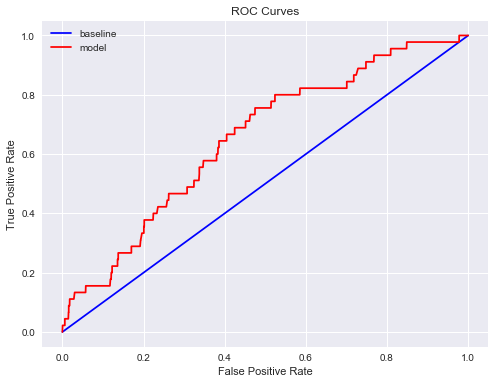

In [48]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [49]:
#Credit to Will Koehrsen for a great Random Forests Tutorial

<h1>Import Original AirBnb Dataset</h1>

In [21]:
sns.set(style="ticks")
seed=42
np.random.seed(seed)
#np.random.seed(sum(map(ord, "axis_grids")))
pd.options.display.max_columns = 20
dir_path = os.path.realpath('')
path = os.path.join(dir_path, 'listings.csv')
df = pd.read_csv(path, header=0, index_col=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 44620 rows, 105 columns.


<h1> Clean and Preprocess Data </h1>

In [22]:
# there are a lot of columns but not all are needed
# we keep the ones we need to calculate yield and for descriptive variables
cols_needed = [
    'description', 
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'square_feet',
    'price', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
    'availability_365', 'reviews_per_month', 'latitude', 'longitude', 'bed_type'
]
df = df[cols_needed]
print("Dataset has {} rows, {} columns.".format(*df.shape))
df.head()

Dataset has 44620 rows, 18 columns.


,description,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,cleaning_fee,guests_included,extra_people,minimum_nights,availability_365,reviews_per_month,latitude,longitude,bed_type
id,,,,,,,,,,,,,,,,,,
109,"*** Unit upgraded with new bamboo flooring, br...",Condominium,Entire home/apt,6,2.0,2.0,3.0,NaN,$122.00,$240.00,3,$25.00,30,98,0.02,33.98209,-118.38494,Real Bed
344,This home is perfect for families; aspiring ch...,House,Entire home/apt,6,1.0,3.0,3.0,NaN,$168.00,$100.00,6,$0.00,2,0,0.16,34.16562,-118.33458,Real Bed
2708,Our best memory foam pillows you'll ever sleep...,Apartment,Private room,1,1.5,1.0,1.0,NaN,$79.00,$89.00,1,$0.00,28,238,0.32,34.09768,-118.34602,Real Bed
2732,This is a three story townhouse with the follo...,Apartment,Private room,1,1.0,1.0,1.0,NaN,$140.00,$100.00,1,$0.00,1,309,0.18,34.00475,-118.48127,Pull-out Sofa
2864,Centrally located.... Furnished with 42 inch S...,Apartment,Entire home/apt,2,1.0,1.0,1.0,NaN,$80.00,$75.00,1,$25.00,2,0,NaN,33.87619,-118.11397,Real Bed


In [23]:
# Clean numeric fields (got rid of the $) because we will make this into one column "price"
num_feats = ['cleaning_fee', 'extra_people', 'price']
df[num_feats] = df[num_feats].replace('[\$,]', '', regex=True)
df[num_feats] = df[num_feats].apply(pd.to_numeric, errors='coerce')
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 44620 rows, 18 columns.


Dataset has 17458 rows, 18 columns.
Dataset has 17458 rows, 17 columns.


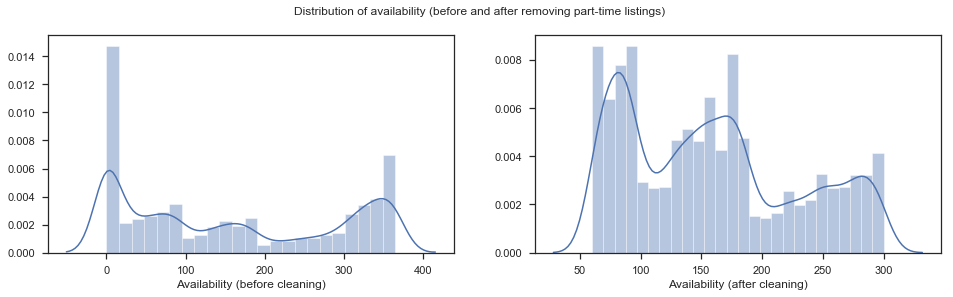

In [24]:
# our data contains many listings that are either rarely available or always available
# we want to do our analysis on listings that are available from 60 days to 300 days a year
# you can tell from the graphs that this helps our data distribution for the listings
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of availability (before and after removing part-time listings)')

x_axis=df['availability_365'].dropna()
sns.distplot(pd.Series(x_axis, name='Availability (before cleaning)'), ax=axs[0])
# Remove where availability less than 60 days or greater than 300 days
df = df.query('60 <= availability_365 <= 300')
print("Dataset has {} rows, {} columns.".format(*df.shape))
x_axis=df['availability_365'].dropna()
sns.distplot(pd.Series(x_axis, name='Availability (after cleaning)'), ax=axs[1])
df = df.drop('availability_365', axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

You dropped 1567 rows.
Dataset has 15418 rows, 17 columns.


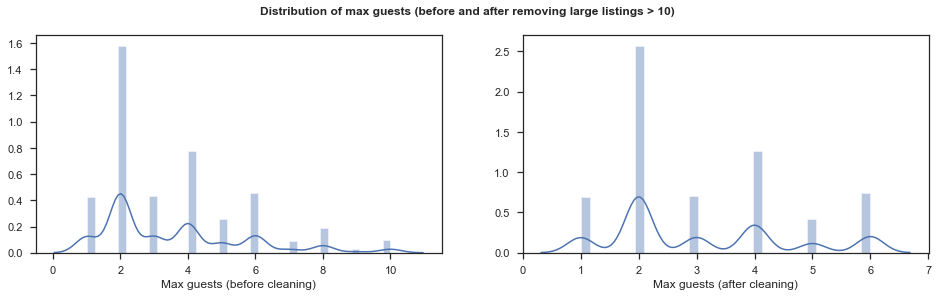

In [26]:
# our data also has many listings that are very large homes
# however, we already know the obvious "bigger homes wil produce a higher yield"
# therefore, we want to get rid of homes that can accomodate more than 6 people 
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of max guests (before and after removing large listings > 10)', weight='bold', fontsize=12)

x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (before cleaning)'), ax=axs[0])
# Remove where accomodates > 6
condition = df[df['accommodates'] > 6]
rows_to_drop = condition.index
print("You dropped {} rows.".format(condition.shape[0]))
df = df.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))
x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (after cleaning)'), ax=axs[1])

You dropped 163 rows.
Dataset has 15096 rows, 17 columns.


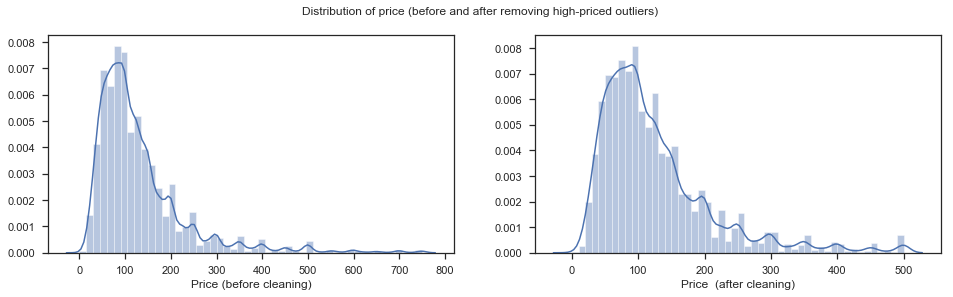

In [28]:
# many listings were posted with a high price
# like the previous cell, we got rid of the listings that had a price > 500
# because bigger homes will produce a larger yield, we don't want to include obvious listings in our analysis
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of price (before and after removing high-priced outliers)')

x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Price (before cleaning)'), ax=axs[0])

# Remove where price > 500
condition = df[df['price'] > 500]
rows_to_drop = condition.index
print("You dropped {} rows.".format(condition.shape[0]))
df = df.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))

x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Price  (after cleaning)'), ax=axs[1])

In [29]:
df['property_type'].value_counts()

Apartment                 5553
House                     4674
Guesthouse                1085
Condominium                912
Guest suite                717
Townhouse                  477
Bungalow                   462
Loft                       358
Villa                      202
Serviced apartment          98
Cottage                     83
Bed and breakfast           69
Hostel                      66
Camper/RV                   65
Boutique hotel              60
Tiny house                  40
Other                       39
Cabin                       32
Hotel                       25
Tent                        12
Aparthotel                  12
Farm stay                    8
Earth house                  8
Tipi                         6
Dome house                   6
Chalet                       5
Castle                       3
Casa particular (Cuba)       3
Yurt                         3
Resort                       2
Barn                         2
Boat                         2
Dorm    

In [30]:
# we only put the less popular property_type to a new category "Other"
categories_to_rename = ['Cottage','Hostel','Bed and breakfast','Camper/RV','Boutique hotel','Tiny house','Cabin',
                        'Hotel','Tent','Aparthotel','Farm stay','Earth house','Campsite','Tipi',
                        'Chalet','Dome house','Yurt','Castle','Boat', 'Casa particular (Cuba)', 'Resort', 'Barn',
                        'Treehouse', 'Bus', 'Dorm', 'Hut', 'Cave', 'Houseboat', 'Serviced apartment', 'Villa']
df['property_type'].loc[df['property_type'].isin(categories_to_rename)] = 'Other'

In [31]:
# we will be using dummy variables for bed_type, so we will put non real beds to a new category "Non-Real Bed"
categories_to_rename = ['Pull-out Sofa', 'Futon', 'Couch', 'Airbed']
df['bed_type'].loc[df['bed_type'].isin(categories_to_rename)] = 'Non-Real Bed'

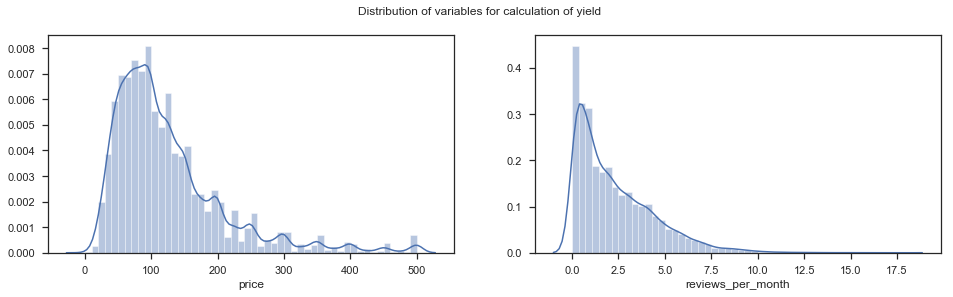

In [32]:
#Distribution of yield, availability_365, reviews_per_month
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of yield')
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1])

In [33]:
# Calculate yield
# Average length of stay (by city) X Price ('price') X No. of reviews('reviews_per_month') / Review rate('50%')
# got information from inside.airbnb los angeles data for yield calc and other numbers
avg_length_of_stay_losangeles = 3
review_rate = 0.5
df['price'] = df['price'] + df['cleaning_fee']
df['yield'] = avg_length_of_stay_losangeles * df['price'] * (df['reviews_per_month'] / review_rate) * 12

cols_to_drop = ['cleaning_fee']
df = df.drop(cols_to_drop, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 15096 rows, 17 columns.


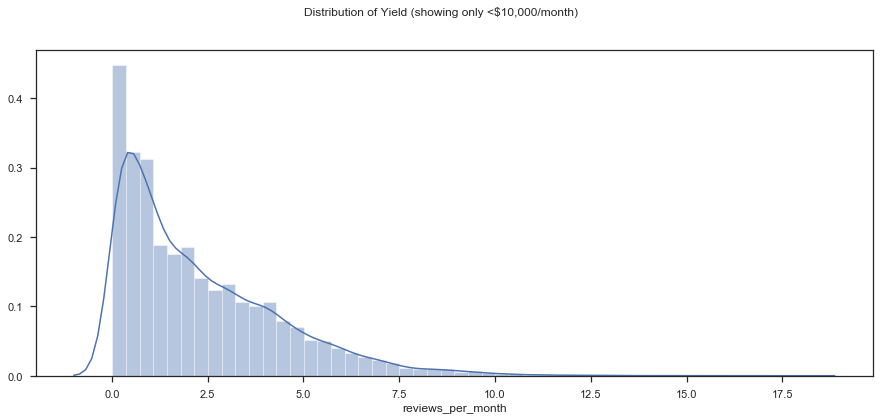

In [34]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,6))
fig.suptitle('Distribution of Yield (showing only <$10,000/month)')
x_axes = df['yield'].dropna()
x = pd.Series(x_axis, name=x_axis.name)
ax = sns.distplot(x)

In [35]:
df['yield'].describe()

count     11855.000000
mean      28823.467566
std       29133.013137
min          86.400000
25%        6765.840000
50%       19245.600000
75%       43440.120000
max      312444.000000
Name: yield, dtype: float64

In [36]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [37]:
# got rid of null values in "yield"
df = df.dropna(subset=['yield'])

# got rid of "square_feet" because the range was too varied and saprse
df = df.drop('square_feet', axis=1)

# Impute most frequent for categorical features
categorical_feats = df.select_dtypes(include=['object']).columns
df[categorical_feats] = DataFrameImputer().fit_transform(df[categorical_feats])

# Impute median for numerical features
num_feats = df.select_dtypes(include=[np.number]).columns
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
df[num_feats] = imp.fit_transform(df[num_feats])

print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 11855 rows, 16 columns.


In [38]:
# check if there are any null values
df.isnull().values.any()

False

In [39]:
# Seperate NLP features for description
nlp_feats = ['description']
corpus = df[nlp_feats]
df = df.drop(nlp_feats, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 11855 rows, 15 columns.


In [40]:
# import additional needed modules
import nltk
nltk.data.path.append("/Users/minjae/nltk_data")

from nltk import word_tokenize#
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import itertools
from collections import Counter
from collections import defaultdict

import json
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [41]:
# now we will clean our descriptions and preprocess our corpus
def preprocess_text(corpus):
    """Takes a corpus in list format and applies basic preprocessing steps of word tokenization,
     removing of english stop words, lower case and lemmatization."""
    processed_corpus = []
    english_words = set(nltk.corpus.words.words())
    english_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[\w|!]+')
    for row in corpus:
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_english if not t in english_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        processed_corpus.append(word_tokens_no_stops_lemmatized)
    return processed_corpus

In [42]:
# we used the nlp_model_pipeline to take our corpus and produce a dictionary, matrix, lda model
# credit to JoaeeChew on github and towardsdatascience for ldatopicmodelling to regression methods
def nlp_model_pipeline(processed_corpus):
    """Takes processed corpus and produce dictionary, doc_term_matrix and LDA model"""
    # Creates the term dictionary (every unique term in corpus is assigned an index)
    dictionary = Dictionary(processed_corpus)
    # Convert corpus into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in processed_corpus]    
    return dictionary, doc_term_matrix
# we used the LDA_topic_modelling to put our descriptions into topics
def LDA_topic_modelling(doc_term_matrix, dictionary, num_topics=3, passes=3):
    # Create an object for LDA model and train it on Document-Term-Matrix
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    return ldamodel
def add_topics_to_df(ldamodel, doc_term_matrix, df, new_col, num_topics):
    # Convert into Per-document topic probability matrix:
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index=df.index, columns=range(0, num_topics))
    docTopicProbDf = docTopicProbDf.apply(pd.to_numeric, errors = 'coerce', axis=0)
    for i, doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i, topic[0]] = topic[1]
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    # Merge with df
    df_new = pd.concat([df, df_topics], axis=1)
    return df_new

In [43]:
# will take around (10-15min)
corpus_description = corpus['description'].astype(str)
processed_corpus_description = preprocess_text(corpus_description)
dictionary_description, doc_term_matrix_description = nlp_model_pipeline(processed_corpus_description)
ldamodel_description = LDA_topic_modelling(doc_term_matrix_description, dictionary_description, num_topics=3, passes=10)
df.describe()

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,reviews_per_month,latitude,longitude,yield
count,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000,11855.000000
mean,3.129819,1.220540,1.149726,1.652467,189.816449,1.832391,16.561029,5.121721,2.304862,34.049604,-118.317548,28823.467566
std,1.499092,0.504589,0.714715,0.991790,117.098746,1.226430,23.886640,14.762096,2.051832,0.113859,0.151520,29133.013137
min,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,1.000000,0.010000,33.338850,-118.934220,86.400000
25%,2.000000,1.000000,1.000000,1.000000,104.000000,1.000000,0.000000,1.000000,0.660000,34.001360,-118.419850,6765.840000
50%,3.000000,1.000000,1.000000,1.000000,168.000000,1.000000,10.000000,2.000000,1.740000,34.060660,-118.335420,19245.600000
75%,4.000000,1.000000,1.000000,2.000000,245.000000,2.000000,25.000000,3.000000,3.490000,34.102525,-118.253050,43440.120000
max,6.000000,11.000000,11.000000,18.000000,1000.000000,16.000000,300.000000,365.000000,15.240000,34.762570,-117.654180,312444.000000


In [45]:
# (will take around 5-10min)
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

p = pyLDAvis.gensim.prepare(ldamodel_description, doc_term_matrix_description, dictionary_description)

pyLDAvis.save_html(p, 'lda1.html')

In [46]:
# price and reviews_per_month are not needed anymore because it is calcualted in yield
cols_to_drop = ['price', 'reviews_per_month']
df_final_viz = df[cols_to_drop]
df = df.drop(cols_to_drop, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 11855 rows, 13 columns.


In [47]:
# we will make dummy variables for the categorical features
categorical_feats = ['property_type', 'room_type', 'bed_type']
df = pd.get_dummies(df, columns=categorical_feats, drop_first=False)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 11855 rows, 24 columns.


In [48]:
# declare X and y(target variable)
target = 'yield'
X = df.drop(target, axis=1)
y = df[target]

In [49]:
# split data to training and test sets
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [50]:
# linear regression
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
regr_y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred))
# Explained variance score: 1 is perfect prediction
print('R-2 score: %.2f' % r2_score(y_test, regr_y_pred))

Mean squared error: 645321710.41
R-2 score: 0.25


In [51]:
# Fit regression model
dt_regr = DecisionTreeRegressor(random_state=seed, max_depth=5)
dt_regr.fit(X_train, y_train)

# Make prediction
dt_y_pred = dt_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, dt_y_pred))
# Explained variance score: 1 is perfect prediction
print('R-2 score: %.2f' % r2_score(y_test, dt_y_pred))

Mean squared error: 587966084.98
R-2 score: 0.32


In [52]:
# fit to random forest regression (took around 10-15 min)
rf_regr = RandomForestRegressor(random_state=seed, bootstrap=True, criterion='mse', max_depth=10, 
                           max_features='auto', min_samples_split=4, n_estimators=100)

rf_regr.fit(X_train, y_train)

# Make prediction
rf_regr.fit(X_train, y_train)
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('R-2 score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 532156988.90
R-2 score: 0.38


In [53]:
df = add_topics_to_df(ldamodel_description, doc_term_matrix_description, df, new_col='topics_description', num_topics=3)

# Rename based on understanding of topics
df['topics_description'].replace({0:'Location', 1:'Luxury', 2:'Budget'},inplace=True)
df = pd.get_dummies(df, columns=['topics_description'], drop_first=False)

print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 11855 rows, 27 columns.


In [55]:
df.head(10)

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,latitude,longitude,yield,...,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Non-Real Bed,bed_type_Real Bed,topics_description_Budget,topics_description_Location,topics_description_Luxury
id,,,,,,,,,,,,,,,,,,,,,
109,6.0,2.0,2.0,3.0,3.0,25.0,30.0,33.98209,-118.38494,521.28,...,0,0,1,0,0,0,1,0,1,0
2708,1.0,1.5,1.0,1.0,1.0,0.0,28.0,34.09768,-118.34602,3870.72,...,0,0,0,1,0,0,1,0,1,0
5728,2.0,1.0,1.0,1.0,1.0,15.0,1.0,33.98833,-118.43224,15552.00,...,1,0,0,1,0,0,1,0,1,0
5729,3.0,1.0,1.0,2.0,2.0,15.0,1.0,33.98685,-118.43266,16516.80,...,0,0,0,1,0,1,0,0,1,0
5843,5.0,1.0,2.0,2.0,2.0,15.0,1.0,33.98782,-118.43170,27855.36,...,0,0,1,0,0,0,1,0,1,0
6931,1.0,1.5,1.0,1.0,1.0,41.0,28.0,34.09521,-118.34801,1750.32,...,0,0,0,1,0,0,1,0,1,0
7874,2.0,1.0,1.0,1.0,1.0,10.0,1.0,33.87610,-118.11509,8366.40,...,0,0,0,1,0,0,1,1,0,0
9140,2.0,1.5,1.0,1.0,1.0,0.0,2.0,33.77206,-118.18893,44100.00,...,0,0,0,1,0,0,1,0,1,0
9545,1.0,1.0,1.0,1.0,1.0,0.0,1.0,33.83823,-118.38569,5544.00,...,0,0,0,1,0,1,0,0,1,0


In [56]:
#Tuning the model for grid search
param_grid = { "n_estimators"      : [175, 200, 225, 250],
           "criterion"         : ['mse'],
           "max_features"      : ['auto'], #auto, sqrt, log2, int/n_feature
           "max_depth"         : [10, 14, 15, 16, 18],
           "min_samples_split" : [6, 7, 8, 9, 10] ,
           "bootstrap": [True]}

In [57]:
# (will take around 10-15min)
rf = RandomForestRegressor(random_state=seed)

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train, y_train)

# Make prediction
rf_y_pred = rf_cv.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))
# Best params
print("Tuned Model Parameters: {}".format(rf_cv.best_params_))

Mean squared error: 514706601.15
Variance score: 0.40
Tuned Model Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 18, 'max_features': 'auto', 'min_samples_split': 7, 'n_estimators': 250}


In [58]:
# Change variables
random_state = 59

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Fit and make prediction
rf_regr.fit(X_train, y_train)
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 529503005.80
Variance score: 0.39


In [59]:
# Change variables
test_size = 0.2

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Fit and make prediction
rf_regr.fit(X_train, y_train)
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 524055226.93
Variance score: 0.40


In [60]:
X_test

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,latitude,longitude,property_type_Apartment,...,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Non-Real Bed,bed_type_Real Bed,topics_description_Budget,topics_description_Location,topics_description_Luxury
id,,,,,,,,,,,,,,,,,,,,,
27702878,2.0,1.0,1.0,1.0,1.0,15.0,3.0,34.04540,-118.35260,1,...,0,0,0,1,0,0,1,0,0,1
22342995,2.0,1.0,1.0,1.0,1.0,20.0,2.0,34.17882,-118.53710,1,...,0,0,0,1,0,0,1,1,0,0
1650397,6.0,0.5,1.0,4.0,4.0,20.0,2.0,33.96115,-118.39348,0,...,0,0,1,0,0,0,1,1,0,0
2488429,2.0,1.0,1.0,1.0,1.0,20.0,2.0,34.06609,-118.33853,0,...,0,0,0,1,0,0,1,0,1,0
33550949,5.0,2.0,2.0,2.0,5.0,25.0,2.0,34.08093,-118.26373,0,...,0,0,1,0,0,0,1,0,1,0
16054009,2.0,1.0,1.0,1.0,1.0,0.0,2.0,34.09143,-118.27187,0,...,0,0,1,0,0,0,1,0,1,0
11551518,3.0,1.0,1.0,1.0,1.0,20.0,2.0,34.20428,-118.62452,0,...,0,0,1,0,0,0,1,1,0,0
34839373,1.0,1.0,1.0,1.0,1.0,10.0,2.0,34.09697,-118.04401,0,...,0,0,0,1,0,0,1,1,0,0
29970349,4.0,1.0,1.0,2.0,2.0,20.0,30.0,34.00383,-118.44488,0,...,0,0,0,1,0,0,1,1,0,0


In [62]:
X_test.loc[16427343]

accommodates                     4.00000
bathrooms                        1.00000
bedrooms                         1.00000
beds                             1.00000
guests_included                  2.00000
extra_people                    20.00000
minimum_nights                   3.00000
latitude                        34.05561
longitude                     -118.35832
property_type_Apartment          1.00000
property_type_Bungalow           0.00000
property_type_Condominium        0.00000
property_type_Guest suite        0.00000
property_type_Guesthouse         0.00000
property_type_House              0.00000
property_type_Loft               0.00000
property_type_Other              0.00000
property_type_Townhouse          0.00000
room_type_Entire home/apt        1.00000
room_type_Private room           0.00000
room_type_Shared room            0.00000
bed_type_Non-Real Bed            0.00000
bed_type_Real Bed                1.00000
topics_description_Budget        0.00000
topics_descripti

In [74]:
#Display feature importance
def feature_importance(model, trainData, display_n_rows):
    """Display feature importance & weighting for tree based model"""
    fi = model.feature_importances_*100
    feat_imp = pd.DataFrame(list(zip(fi,trainData.columns.values)))
    feat_imp = feat_imp.sort_values(by=0, axis=0, ascending=False)
    feat_imp.columns = ['importance %', 'feature']
    print(feat_imp[:display_n_rows])
    
#Display features & weighting
rf_best = rf_cv.best_estimator_
feature_importance(rf_best, X_train, 25)

    importance %                    feature
18     19.771348  room_type_Entire home/apt
8      18.402017                  longitude
7      17.267060                   latitude
6      16.332640             minimum_nights
0       5.608063               accommodates
5       5.377110               extra_people
4       4.215833            guests_included
3       2.712017                       beds
2       2.017625                   bedrooms
1       1.781013                  bathrooms
9       1.247877    property_type_Apartment
14      0.933929        property_type_House
13      0.852205   property_type_Guesthouse
12      0.674690  property_type_Guest suite
11      0.661870  property_type_Condominium
10      0.620370     property_type_Bungalow
16      0.457258        property_type_Other
17      0.445385    property_type_Townhouse
15      0.440846         property_type_Loft
20      0.062645      room_type_Shared room
19      0.049437     room_type_Private room
22      0.037100          bed_ty